# Импорт библиотек и загрузка данных

In [ ]:
# Библиотека для работы с массивами данных
import numpy as np

# Интерфейс для построения графиков простых функций
from matplotlib import pyplot as plt

# Загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from IPython.display import Audio

# Библиотека для параметризации аудио
import librosa

# Модуль для работы с каталогами
import os

# Модуль для разбивки данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import to_categorical

# Быстрый и удобный progress bar для Python
from tqdm import tqdm

# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta

# Последовательная модель нейросети кераса
from tensorflow.keras.models import Sequential

# Загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape

# Библиотека для воспроизведения звуковых файлов
import IPython.display as ipd

# Загрузка датасетов из облака google
import gdown

In [ ]:
# Данные для обучения
url = 'https://drive.google.com/uc?id=1oChyms0wc8vwbtHvow-tSQLoFteIZDuj'
gdown.download(url, None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oChyms0wc8vwbtHvow-tSQLoFteIZDuj
To: /content/data_train_robot.zip
100%|██████████| 122M/122M [00:04<00:00, 27.8MB/s]


'data_train_robot.zip'

In [ ]:
# Разархивируем обучающие данные
!unzip -q '/content/data_train_robot.zip' -d /content

# Разархивируем тестовые данные
#!unzip -q '/content/test.zip' -d /content/test

In [ ]:
# Зададим путь к папке с аудиофайлами
DATA_PATH = "/content/data_train_robot/"

# Зададим пусть к файлу с тестовыми 30-тисекнудными аудиофайлами
DATA_PATH_TEST = "/content/data_test_robot/"

## Объявление функций



Зададим параметры данных, которые пойдут на вход нейросети:

In [ ]:
sample_rate = 24000                   # Значение sample_rate аудиофайлов
feature_dim_1 = 20                    # Стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # Длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate)    # Шаг смещения (в секундах 0.1 = 100мс)
channel = 1                           # Количество каналов
n_classes = 10                        # Количество классов команд (4-ый класс - шум)

classes = [
          'РОБОТ',
          'СТОЙ',
          'ВПЕРЕД',
          'НАЗАД',
          'ВЛЕВО',
          'ВПРАВО',
          'РАСЖАТЬ',
          'КЛЕШНЮ',
          'СЖАТЬ'
]

In [ ]:
def get_labels(path=DATA_PATH):

  '''
  Функция извлечения лейблов классов и их обработки

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами

  Returns:
    labels - имена лейблов, str
    label_indices - индексы лейблов, int
    to_categorical(label_indices) - ohe лейблов
  '''

  # Запишем лейблы классов по названию папок - ['кондиционер', 'телевизор', 'свет', 'фон']
  labels = sorted(os.listdir(path))

  # Запишем лейблы в виде индексов - [0, 1, 2, 3]
  label_indices = np.arange(0, len(labels))

  # Функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]
  return labels, label_indices, to_categorical(label_indices)

In [ ]:
# Выведем имена лейблов
l,_,_ = get_labels()
l

['0_robot',
 '1_stop',
 '2_forward',
 '3_backwards',
 '4_left',
 '5_right',
 '6_unclench',
 '7_claw',
 '8_squeeze',
 '9_noise']

Следующая функция `wav2mfcc` преобразует аудиозапись в `mfcc`. Если на классификацию подавать просто сигнал (последовательность отчетов), то классификация работает плохо, поэтому мы будем подавать `mfcc`.

Можно попробовать преобразовать сигнал и во что-нибудь другое, например спектральный центроид, или `stft` и делать классификацию по таким данным.

На вход этой функции приходит аудиозапись, мы её разрезаем на кусочки длины `length` с шагом `step`, преобразуем их в `mfcc` и сохраняем в список.

Значения `length` и `step` не в секундах, а в отчетах. Каждая секунда записи содержит 22050 отчетов, следовательно `length` = 11025 это пол секунды, а `step` = 2205 это десятая часть секунды.

In [ ]:
def wav2mfcc(file_path,
             length = 11025,
             step = 2205):
  '''
  Функция параметризации аудио(wav в мел-частоты)

  Args:
    file_path - путь к аудио файлу
    length - длинна отрезков, на которые разбиваем исходный файл, int
    step - шаг, на который смещаем разбиение отрезка, int

  Returns:
    out_mfcc - массив мел-частот
    out_audio - массив аудио-отрезков
  '''

  # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_mfcc = []

  # Выходной массив, содержащий аудиоинформацию исходного файла с шагом step
  out_audio = []

  # Загружаем данные исходного файла
  y, sr = librosa.load(file_path)

  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
  while (len(y)>=length):

    # Берем начальный кусок длинной length
    section = y[:length]
    # Переводим в numpy
    section = np.array(section)
    # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_mfcc.append(librosa.feature.mfcc(y=section,sr= sr))
    # Добавляем в выходной массив аудио текущий кусок
    out_audio.append(section)
    # Уменьшаем y на step
    y = y[step:]

  # Преобразуем в numpy
  out_mfcc = np.array(out_mfcc)

  # Преобразуем в numpy
  out_audio = np.array(out_audio)

  # Функция вернет массив мел-частот и массив аудио-отрезков
  return out_mfcc, out_audio

Следущая функция `save_data_to_array` позволяет пройти по всем аудиозаписям и применить к ним предыдущую функцию `wav2mfcc`. После этого все данные сохраняются в директории в виде массива numpy (отдельный файл для каждого класса).

In [ ]:
def save_data_to_array(path=DATA_PATH,
                       length=11025):
  '''
  Функция формирования и сохранения векторов данных,
  полученных для каждого набора аудио-команд в датасете

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами
    length - длинна отрезков, на которые разбиваем исходный файл

  Returns:

  '''

  # Извлекаем лейблы классов
  labels, _, _ = get_labels(path)

  # Проходим циклом по каждому лейблу
  for label in labels:

    # Собираем векторы MFCC частот
    mfcc_vectors = []
    # Извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

    # Для каждого файла
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)):
      # Получим мел-частоты
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc)

      # Если массив не нулевой длинны
      if (mfcc.shape[0] != 0 ):
        # Добавим вектор в список для соответствующего класса
        mfcc_vectors.extend(mfcc)

    # Сохраним массивы данных для каждого класса
    np.save(label + '.npy', mfcc_vectors)

Функция `get_train_test()` разделяет данные на обучающую и проверочную выборки.

In [ ]:
def get_train_test(split_ratio=0.7,
                   random_state=42,
                   colab = True):
  '''
  Функция для получения обучающей/проверочной выборки

  Args:
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split, float [0..1]
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split, int
    colab - запускаем код в колабе или нет, bool

  Returns:
    4 массива обучающих и проверочных данных
  '''

  labels, indices, _ = get_labels(DATA_PATH)  # Извлекаем имена и индексы лейблов классов
  X = np.load('/content/'+labels[0] + '.npy') # Берем набор векторов для первого класса
  y = np.zeros(X.shape[0], dtype = 'int32')   # Устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]):

    # Условие, если запускаем а колабе
    if colab:
      # Читаем очередной массив данных
      x = np.load(label + '.npy')
    else:
      # Читаем очередной массив данных
      x = np.load('/content/'+label + '.npy')

    # Соединяем с исходным набором
    X = np.vstack((X, x))

    # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

  # Разделяем данные на обучающую и проверочную выборки
  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете или загружаем ниже

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
# ВНИМАНИЕ! Ячейка будет обрабатывать файлы около 8 минут

save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - '9_noise': 100%|██████████| 50/50 [08:34<00:00, 10.29s/it]


In [ ]:
import zipfile
import os

# Директория с файлами .npy
source_folder = '/content/'

# Имя архива, в который будут добавлены файлы
zip_filename = 'data_archive_robot.zip'

# Создаем архив
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Перебираем файлы в указанной директории
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith(".npy"):  # Проверяем, что файл имеет расширение .npy
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, source_folder)  # Относительный путь от source_folder
                zipf.write(file_path, arcname)

print(f'Архив "{zip_filename}" создан успешно.')

Архив "data_archive_robot.zip" создан успешно.


# Загрузка предобработанных данных

In [ ]:
# Загрузка обработанного датасетов из облака
gdown.download('https://drive.google.com/uc?id=1KtzMBZhe8fCSAGEgs2WOwsyM55iDDxPo', None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KtzMBZhe8fCSAGEgs2WOwsyM55iDDxPo
To: /content/data_archive_robot.zip
100%|██████████| 170M/170M [00:07<00:00, 23.0MB/s]


'data_archive_robot.zip'

In [ ]:
!unzip -q data_archive_robot.zip

In [ ]:
# Формируем обучающую и проверочную выборки

x_train, x_test, y_train, y_test = get_train_test(colab=False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(69283, 20, 24) (69283,)
(29693, 20, 24) (29693,)


In [ ]:
# Добавляем ещё одну размерность в конце 'x' выборок, для использования сверток

x_train = x_train[..., None]
x_test = x_test[..., None]

# Представляем лейблы классов обучающего и проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [ ]:
# Выведем размерность x_train
x_train.shape

(69283, 20, 24, 1)

In [ ]:
# Посмотрим сколько примеров имеет класс шум

idx = np.where(y_train==3)
idx[0].shape

(2542,)

# Нейросеть



In [ ]:
# Объявим функцию создания модели нейросети

def get_model():

  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Flatten())                      # Сплющиваем в одномерный вектор
  model.add(Dense(128, activation='relu'))  # Добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # Добавляем полносвязный слой с функцией активации softmax на выходном слое для 4 классов

  # Компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate = 0.007), # 0.01 - 0.005
                metrics=['accuracy'])

  return model

In [ ]:
# Создаем модель с помощью объявленной ранее функции

model = get_model()

Запустим тренировку нейросети на полученных данных

Epoch 1/100
271/271 [==============================] - 13s 9ms/step - loss: 0.6964 - accuracy: 0.7424 - val_loss: 0.6055 - val_accuracy: 0.7688
Epoch 2/100
271/271 [==============================] - 2s 6ms/step - loss: 0.5505 - accuracy: 0.7823 - val_loss: 0.5136 - val_accuracy: 0.7951
Epoch 3/100
271/271 [==============================] - 2s 6ms/step - loss: 0.5205 - accuracy: 0.7928 - val_loss: 0.4912 - val_accuracy: 0.8056
Epoch 4/100
271/271 [==============================] - 2s 6ms/step - loss: 0.4980 - accuracy: 0.8032 - val_loss: 0.4809 - val_accuracy: 0.8069
Epoch 5/100
271/271 [==============================] - 2s 9ms/step - loss: 0.4907 - accuracy: 0.8053 - val_loss: 0.4632 - val_accuracy: 0.8130
Epoch 6/100
271/271 [==============================] - 2s 6ms/step - loss: 0.4703 - accuracy: 0.8136 - val_loss: 0.4541 - val_accuracy: 0.8204
Epoch 7/100
271/271 [==============================] - 2s 6ms/step - loss: 0.4668 - accuracy: 0.8143 - val_loss: 0.4411 - val_accuracy: 0.824

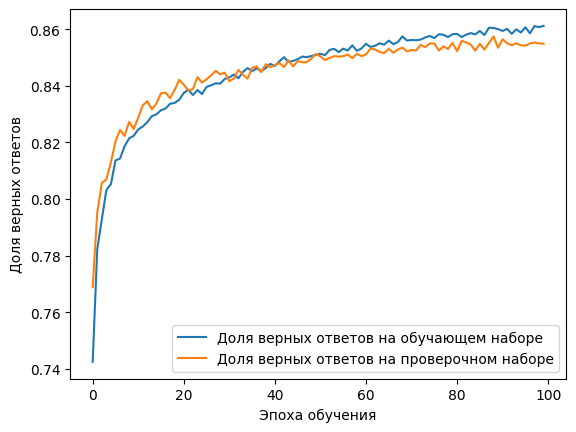

In [ ]:
# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика

history = model.fit(x_train,
                    y_train_hot,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверка


Для проверки мы будем использовать аудиофайлы, в которых наговаривается произвольный текст и иногда произносится одна из фраз из списка команд

In [ ]:
model.load_weights('4_SpeechToText_pro.h5')

In [ ]:
# Загрузка сохраненных весов из облака
gdown.download('https://drive.google.com/uc?id=1nPZdnrB-S65sZgjd2Mx6B1qqEpOW4OIA', None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nPZdnrB-S65sZgjd2Mx6B1qqEpOW4OIA
To: /content/data_test_robot.zip
100%|██████████| 6.96M/6.96M [00:00<00:00, 15.6MB/s]


'data_test_robot.zip'

In [ ]:
!unzip -q data_test_robot.zip -d data_test_robot

In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + '8.wav'

# Загружаем данные модулем librosa
y,sr = librosa.load(wavfiles)

# Выводим оригинальный аудиофайл (Команда "Кондиционер" начинается на 12 секунде)
print('Оригинальный файл:')
ipd.Audio(data=y, rate = sr)

Оригинальный файл:


In [ ]:
# Получаем массив mfcc выбранного файла с именем namefile
mfcc_full, audio_full = wav2mfcc(wavfiles, length=feature_dim_2, step = step_mfcc)
print(mfcc_full.shape)

# Решейпим для сверточного слоя
#mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
#mfcc_full = mfcc_full.reshape(-1, 20, 47, 1)
mfcc_full = mfcc_full.reshape(-1, 20, 24, 1)

# Предиктим с помощью модели model массив mfcc
g_pred = model.predict(mfcc_full)

# Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов
pred = np.array([np.argmax(i) for i in g_pred])

(349, 20, 24)
11/11 [==============================] - 0s 5ms/step


In [ ]:
print(g_pred.shape)

print(pred.shape)

print(pred[:1000])

(349, 10)
(349,)
[6 8 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 7 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 4 4 3 4 2 0 0 0
 0 0 2 0 6 6 6 6 7 7 4 4 4 4 2 6 1 6 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 4 4 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 4 4 4 4
 4 4 4 0 4 4 0 0 5 5 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 4 4 4 4 2 2 2 2 2
 2 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 4 2 4 4 2 2 2 2 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 0 0 0 2 0 0 1 1 1 1 1 1 8 8 6 2 2 7 7 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 7 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 0 0 0 0 0 0 0 0]


In [ ]:
# Выводим уникальные значения классов - проверяем, что есть только целевые значения
num_lable = set(pred)
print(num_lable)

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [ ]:
model.save_weights('4_SpeechToText_pro.h5') # - Сохраняем веса

#Целевое значение достигнуто изменением параметра learning_rate = 0.007.
Конечно, в других случаях, потребуется изменение как параметров обучения, так и конфигурации нейронной сети, а также возможно изменения принципов предобработки данных.

In [ ]:
# В массиве pred находим все элементы со значением, равным искомому классу idx_class
idxs = np.where(pred == 0)

# Размерность полученного масива в np.where имеет тип (x,). Оставляем только первую размерность
idxs = idxs[0]
print(idxs)

[ 26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  71  72  73  74  75  77 110 111 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 140 141 142 143
 151 154 155 158 159 160 161 162 163 164 165 166 167 174 175 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 265 266 267
 268 270 271 296 297 298 299 300 301 302 303 304 305 306 341 342 343 344
 345 346 347 348]


In [ ]:
# Минимальная длина последовательности одного класса

min_count = 8

In [ ]:
# Порог среднего значения вероятности

rate = 0.95

In [ ]:
# Временный массив для хранения информации о найденных командах

curr = []

In [ ]:
# Текущий стартовый индекс
curr_idx = int(idxs[0])

# summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу;
summ = 0

# length - длина последовательно идущих элементов для одной команды
length = 0

In [ ]:
for i in range(len(idxs)):   # Пробегаем по всему массиву idxs

  # Считаем сумму вероятности
  summ += g_pred[idxs[i]][0]
  # Увеличиваем длину последовательности
  length += 1

  # Если последний элемент последовательности
  if i == len(idxs)-1:

    # Проверяем условия
    if (length >= 2 and summ / length >= rate):
      # Если условия выполняются
      curr.append([curr_idx, length, summ / length])
    break

  # Если элемент относится к другой команде
  if idxs[i+1]-idxs[i]>1:

    # Проверяем условия
    if (length >= min_count and summ / length >= rate):
      # Если условия выполняются
      curr.append([curr_idx, length, summ / length])

    # Изменяем текущий стартовый индекс
    curr_idx = int (idxs[i+1])
    # Обнуляем summ и length
    summ, length = 0, 0

# Выведем на экран результат
print(curr)

[[26, 18, 0.9918809764915042], [113, 24, 0.9709411486983299], [187, 14, 0.9752551232065473], [217, 22, 0.986038478938016]]


In [ ]:
np_Audio = []     # Список для полного mfcc
curr_audio = []   # mfcc отдельной команды

In [ ]:
# Проходим по всему массиву curr
for elem in curr:

  # Записываем в переменную первый элемент распознанной команды
  curr_audio = audio_full[elem[0]]

  # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее
  if (elem[0] != 0):
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))

  # Пробегаем циклом от 1 до elem[1] (где elem[1] - количество отрезков этого класса в последовательности)
  for j in range(1,elem[1]):

    # Если elem[0] + j равно длинне mfcc, то выходим из цикла
    if (elem[0]+j == len(audio_full)):
      break

    # Соединяем кусочки mfcc вместе
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))

  # Переводим массив в numpy
  curr_audio = np.array(curr_audio)

  # Добавляем данные в выходной массив
  np_Audio.append([curr_audio, elem[2]])

# Выведем длину итоговой распознанной команды
print(len(curr_audio))

22560


In [ ]:
# Если длина массива равна 0, то команда не распознана
if (len(np_Audio)==0):
    print('Команда не распознанана!!!')

# Пробегам по всем элементам массива out
for elem in np_Audio:
    print('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)') # Выводим название
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " РОБОТ " (вероятность - 99.19 %)


Распознана команда: " РОБОТ " (вероятность - 97.09 %)


Распознана команда: " РОБОТ " (вероятность - 97.53 %)


Распознана команда: " РОБОТ " (вероятность - 98.60 %)


Команду РОБОТ выделил, но выделил и ошибочно другие кусочки текста.
Текст довольно искусственен, возможно нужно изменить сам подход. На данных 10_noise использовались из урока, текст был записан на частоте 22 КГц, возможно в этом причина. Причина может крытся также в том, что диктор шумовых данных один и он не совпадает с другими дикторами. Попробую на неделе. Но два слова, как задумывалось и пыталось, не выдал. будем пробовать.